$margin_{added, normalized} = \frac{margin_{promo} - margin_{regular}}{sales_{regular}}$

In [1]:
from data import load_checks, load_objects

In [2]:
objects = load_objects('data')

In [3]:
import pandas as pd

In [4]:
from datetime import timedelta

def promo_start(date):
    # Cчитаем что все акции стартуют по четвергам
    # Определяем ближайший предыдущий четверг
    return date - timedelta(days=(date.isoweekday() - 4) % 7)

In [5]:
objects['promo_start'] = objects.start_date.apply(promo_start)

In [6]:
promo_type = 'Biweekly'

In [7]:
objects['selected_promo'] = objects['Promo_type'].isin([promo_type])

In [8]:
objects['length'] = (objects['end_date'] - objects['start_date']).apply(lambda x: 1+ x.days)

In [9]:
objects['selected_promo'] &= objects['length'] == 14

In [10]:
def explode_days(objects):
    objects['day'] = objects[['start_date', 'end_date']].apply(lambda x: pd.date_range(x['start_date'], x['end_date'], freq='D'), axis=1)
    return objects.explode('day')

objects = explode_days(objects)

In [11]:
objects.columns

Index(['Promo_type', 'Offer_ID', 'sku', 'start_date', 'end_date',
       'train_test_group', 'promo_start', 'selected_promo', 'length', 'day'],
      dtype='object')

In [12]:
full_checks = load_checks('data')
checks = full_checks.copy()

In [13]:
# Смотрим только продажи товаров которые присутствовали в интересующих нас промо 
checks = checks.merge(objects[objects['selected_promo'] == True][['sku']].drop_duplicates(), on='sku')
checks.shape

(1816422, 14)

In [14]:
checks = checks.merge(
    objects[['sku', 'day', 'selected_promo', 'Promo_type', 'Offer_ID']],
    on=['sku', 'day'],
    how='left',
)

In [15]:
checks['promo_start'] = checks['day'].apply(promo_start)

In [16]:
sku_promo_sales = checks.groupby(['sku', 'promo_start']).agg(
    {
        'promo_id': 'count',
        'sales': 'sum',
        'supplier_sales': 'sum',
        'num_sales': 'sum',
        'Promo_type': 'first',
        'Offer_ID': 'first',
        'selected_promo': 'first',
    }
)

In [17]:
sku_promo_sales = sku_promo_sales.rename({'promo_id': 'count_checks'}, axis=1)

In [18]:
sku_promo_sales['margin'] = sku_promo_sales['sales'] - sku_promo_sales['supplier_sales']

In [19]:
sku_promo_sales['price'] = sku_promo_sales['sales'] / sku_promo_sales['num_sales']

In [20]:
sku_promo_sales['item_margin'] = sku_promo_sales['margin'] / sku_promo_sales['num_sales']

In [21]:
sku_promo_sales = sku_promo_sales.reset_index()

In [22]:
sku_promo_sales.groupby('sku').agg({'sales': 'sum'}).sort_values('sales', ascending=False).head(10)

,sales
sku,
119a9ea3a832472e1c163e5c1afba59e,11040500.40
ca544f2ea6030dae031adc5a72dde275,4800212.89
8f4b2b5d481140b01c5b20bbf493b2b9,4209821.44
962b727f1de1e02bb2a538fd479a8ceb,2767084.12
0e2823baca6c23c591c96e7399a74ae6,2659829.22
93c2501c8c39b1d2476abb3d73739933,2584842.45
0b689fd70e79d5010e397b4c453e8460,2468665.64
fcd6037cb75c6211110747eacf3e4200,2180441.33
b5a6bbeeb9ef82b186e0479701dbadf5,1881952.57


In [23]:
median_price = sku_promo_sales.groupby('sku')['price'].rolling(17, center=True, min_periods=8).median().reset_index()['price']

In [24]:
sku_promo_sales['usual_price'] = median_price

In [25]:
regular = sku_promo_sales[sku_promo_sales['selected_promo'].isna()]

In [26]:
sku_regular_margin = regular.groupby('sku').agg({'margin': 'mean', 'sales': 'mean'}).sort_values('margin', ascending=False)
sku_regular_margin['margin_rank'] = sku_regular_margin['margin'].rank(ascending=False)
sku_regular_margin['sales_rank'] = sku_regular_margin['sales'].rank(ascending=False)

In [27]:
sku_regular_margin = sku_regular_margin.rename({'sales': 'sales_regular'}, axis=1)

In [28]:
promo = sku_promo_sales[sku_promo_sales['selected_promo'] == True]

In [29]:
promo = promo.merge(sku_regular_margin, on='sku', suffixes=['', '_regular'])

In [30]:
promo['added_margin'] = promo['margin'] - promo['margin_regular']
promo['relative_added_margin'] = promo['added_margin'] / promo['sales_regular']

In [31]:
# План:

# Добавляем фичи: сколько недель от последнего промо
# Продаваемость товара (ранк)
# Маржинальность товара (ранк)
# Первая неделя промо (не хватает данных, надо больше года)
# Категория товара

In [32]:
# Предсказываем для каждого из вариантов и оптимизируем календарь максимизируя added 

In [33]:
promo['week_number'] = promo['promo_start'].apply(lambda date: date.isocalendar()[1])

In [34]:
from catboost import CatBoostRegressor

In [35]:
model = CatBoostRegressor(loss_function='RMSE') # Нужно выбрать лосс который не дает смещение, например RMSE (MAE - не подойдет)

In [36]:
features = ['week_number', 'margin_rank', 'sales_rank']
target = 'relative_added_margin'

In [37]:
model.fit(promo[features], promo[target], metric_period=100)

Learning rate set to 0.050655
0:	learn: 0.9567222	total: 53.1ms	remaining: 53.1s
100:	learn: 0.6595510	total: 219ms	remaining: 1.95s
200:	learn: 0.6042121	total: 385ms	remaining: 1.53s
300:	learn: 0.5564461	total: 550ms	remaining: 1.28s
400:	learn: 0.5122073	total: 715ms	remaining: 1.07s
500:	learn: 0.4770418	total: 884ms	remaining: 881ms
600:	learn: 0.4512486	total: 1.05s	remaining: 697ms
700:	learn: 0.4297795	total: 1.22s	remaining: 521ms
800:	learn: 0.4108290	total: 1.39s	remaining: 345ms
900:	learn: 0.3937950	total: 1.55s	remaining: 171ms
999:	learn: 0.3775915	total: 1.72s	remaining: 0us


In [38]:
# Сгененируем возможные варианты промо для календаря

In [39]:
promo[['promo_start', 'week_number']].drop_duplicates().sort_values('promo_start')

,promo_start,week_number
69,2019-10-03,40
70,2019-10-10,41
56,2019-10-17,42
222,2019-10-24,43
40,2019-10-31,44
41,2019-11-07,45
6,2019-11-14,46
7,2019-11-21,47
38,2019-11-28,48
39,2019-12-05,49


In [40]:
import datetime

all_predictions = []
# Первые 3 недели пропустим, поскольку в прошлом году не было 2-х недельных промо в этот период 
first_week = datetime.date(2021, 1, 7)
for week_number in range(3, 13):
    promo_start = first_week + datetime.timedelta(weeks=week_number - 1)
    print(promo_start, week_number)
    for sku in promo.sku.unique():
        all_predictions.append({
            'week_number': week_number, 
            'promo_start': promo_start,
            'sku': sku,
        })
        
all_predictions = pd.DataFrame(all_predictions)
all_predictions = all_predictions.merge(sku_regular_margin, on='sku', suffixes=['', '_regular'])

2021-01-21 3
2021-01-28 4
2021-02-04 5
2021-02-11 6
2021-02-18 7
2021-02-25 8
2021-03-04 9
2021-03-11 10
2021-03-18 11
2021-03-25 12


In [41]:
all_predictions[target] = model.predict(all_predictions[features])
all_predictions['added_margin'] = all_predictions['relative_added_margin'] * all_predictions['sales_regular']
all_predictions = all_predictions.set_index(['sku', 'promo_start', 'week_number'])

In [42]:
all_predictions[['added_margin', 'sales_regular', 'relative_added_margin']].head(30)

added_margin  \
sku                              promo_start week_number                 
00218695e83d28a79151ef327e51200c 2021-01-21  3             -598.085914   
                                 2021-01-28  4             -598.085914   
                                 2021-02-04  5             -622.613683   
                                 2021-02-11  6             -652.552172   
                                 2021-02-18  7             -644.878049   
                                 2021-02-25  8             -734.806081   
                                 2021-03-04  9             -781.464743   
                                 2021-03-11  10           -1113.120575   
                                 2021-03-18  11           -1065.088077   
                                 2021-03-25  12            -447.529482   
002efbd1c274c4d3dd21e48787124a93 2021-01-21  3              495.335666   
                                 2021-01-28  4              495.335666   
                                 2021-02-04  5              550.610443   
                                 2021-02-11  6             1763.192905   
                                 2021-02-18  7             2200.609280   
                                 2021-02-25  8             3676.656706   
                                 2021-03-04  9             2712.986501   
                                 2021-03-11  10            2876.469947   
                                 2021-03-18  11            2661.438212   
                                 2021-03-25  12            2055.554669   
00432d021eca6059fee2ed69a732c2b2 2021-01-21  3              352.091097   
                                 2021-01-28  4              352.091097   
                                 2021-02-04  5              477.426886   
                                 2021-02-11  6             1211.105846   
                                 2021-02-18  7             1506.219129   
                                 2021-02-25  8             2365.315428   
                                 2021-03-04  9             2025.062815   
                                 2021-03-11  10            2116.786142   
                                 2021-03-18  11            1929.599736   
                                 2021-03-25  12            1311.722107   

                                                          sales_regular  \
sku                              promo_start week_number                  
00218695e83d28a79151ef327e51200c 2021-01-21  3               905.934054   
                                 2021-01-28  4               905.934054   
                                 2021-02-04  5               905.934054   
                                 2021-02-11  6               905.934054   
                                 2021-02-18  7               905.934054   
                                 2021-02-25  8               905.934054   
                                 2021-03-04  9               905.934054   
                                 2021-03-11  10              905.934054   
                                 2021-03-18  11              905.934054   
                                 2021-03-25  12              905.934054   
002efbd1c274c4d3dd21e48787124a93 2021-01-21  3              3601.256364   
                                 2021-01-28  4              3601.256364   
                                 2021-02-04  5              3601.256364   
                                 2021-02-11  6              3601.256364   
                                 2021-02-18  7              3601.256364   
                                 2021-02-25  8              3601.256364   
                                 2021-03-04  9              3601.256364   
                                 2021-03-11  10             3601.256364   
                                 2021-03-18  11             3601.256364   
                                 2021-03-25  12             3601.256364   
00432d021eca6059fee2ed69a732c2b2 2021-0

In [43]:
# Поскольку в 2020 году в первый квартал основная часть товаров была в двухнедельной промо акции не более одного раза, 
# мы выберем самую лучшую позицию для промо-акции по каждому товару

In [44]:
calendar = []

for sku, predictions in all_predictions.groupby('sku'):
    predictions['biweekly_added_margin'] = predictions['added_margin'][::-1].rolling(window=2).sum()
    max_week = predictions['biweekly_added_margin'].idxmax()
    max_week, predictions.loc[max_week, 'biweekly_added_margin']
    calendar.append({
        'biweekly_added_margin': predictions.loc[max_week, 'biweekly_added_margin'],
        'sku': max_week[0],
        'promo_start': max_week[1],
        'week_number': max_week[2],
    })

In [45]:
calendar = pd.DataFrame(calendar).set_index('sku')

In [46]:
promo[promo.week_number < 13].promo_start.value_counts()

2020-02-06    107
2020-02-13    100
2020-03-19     92
2020-01-23     79
2020-01-30     79
2020-02-27     70
2020-02-20     69
2020-03-05     62
2020-03-12     62
Name: promo_start, dtype: int64

In [47]:
calendar.promo_start.value_counts()

2021-02-25    776
2021-01-21    376
2021-03-11    172
2021-02-18     45
2021-02-04     44
2021-01-28     36
2021-03-18     35
2021-02-11     22
2021-03-04      4
Name: promo_start, dtype: int64

In [48]:
# Размер календаря как и ожидался одинаковый (в календаре объединены пары недель промо)
calendar.shape, promo[promo.week_number < 13].shape

((1510, 3), (720, 20))

In [49]:
calendar['biweekly_added_margin'].sum().round(-3)

4898000.0

In [50]:
promo['added_margin'].sum().round(-3)

2997000.0

In [51]:
old_calendar = promo[['sku', 'promo_start']].groupby('sku').agg({'promo_start': 'min'})

In [52]:
# Прогнозное увеличение прибыли для календаря
added_margin_calendar_total = calendar['biweekly_added_margin'].sum() / promo['added_margin'].sum() - 1
f"{added_margin_calendar_total:.0%}"

'63%'

<AxesSubplot:xlabel='promo_start'>

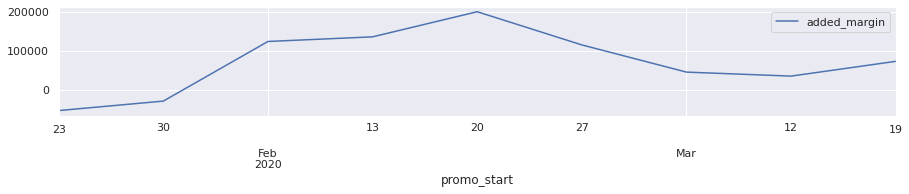

In [53]:
%matplotlib inline

import seaborn
seaborn.set()
promo[promo.week_number < 13].groupby('promo_start').agg({'added_margin': 'sum'}).plot(figsize=(15, 2))

In [54]:
calendar_exploded = calendar[['promo_start']].copy()
calendar_exploded['promo_start'] = calendar_exploded['promo_start'].apply(
    lambda date: [date, date + datetime.timedelta(weeks=1)]
)
calendar_exploded = calendar_exploded.explode('promo_start')
calendar_exploded

,promo_start
sku,
00218695e83d28a79151ef327e51200c,2021-01-21
00218695e83d28a79151ef327e51200c,2021-01-28
002efbd1c274c4d3dd21e48787124a93,2021-02-25
002efbd1c274c4d3dd21e48787124a93,2021-03-04
00432d021eca6059fee2ed69a732c2b2,2021-02-25
...,...
ff4bf06e9bb85df257d5d080e1d9b4e5,2021-03-04
ff608c85ac3bd4ca8568b28746d86ee7,2021-01-21
ff608c85ac3bd4ca8568b28746d86ee7,2021-01-28


<AxesSubplot:xlabel='promo_start'>

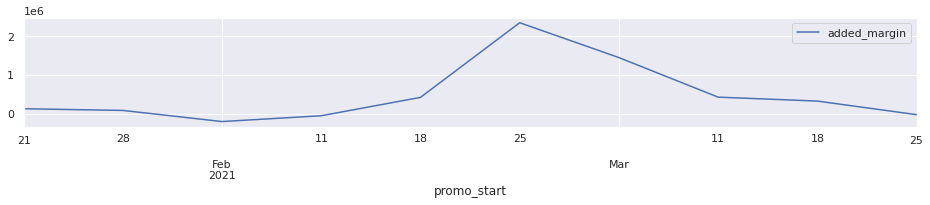

In [55]:
%matplotlib inline

import seaborn
seaborn.set()
all_predictions.merge(calendar_exploded, on=['sku', 'promo_start']).groupby('promo_start').agg({'added_margin': 'sum'}).plot(figsize=(16, 2))

In [56]:
all_predictions.merge(calendar_exploded, on=['sku', 'promo_start'])['added_margin'].sum()

4898024.918584161